# Cluster Analysis - Boudart

#### WARNING: THIS NOTEBOOK TAKES OVER 24 HOURS TO RUN. A SLIM DOWN VERSION WILL BE PROVIDED.

The goal of this notebook is to explore the data structure for hidden clusters. Good clusters have high intra-class similarity and low inter-class similarity. Good clustering produces clusters where points within a cluster are similar and dissimilar from points in different clusters. We hope to find good clusters in the data we could exploit by fitting classification models on individual clusters instead of the entire dataset. We expect the models for individual clusters to be more accurate and provide better results than a single model fitted on the entire dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import warnings
%matplotlib inline

In [2]:
# Format output of data frame. 
pd.set_option("precision", 4)
pd.set_option('display.max_columns', None)

In [3]:
# Load the data with all columns
wpFull = pd.read_csv('../data/pump_train_final.csv')

# Obtain region column as a categorical data type.
regionDF = pd.DataFrame({'regionObj': wpFull['region_code']}, dtype=np.dtype("object"))


In [4]:
# Load the reduced data
wp = pd.read_csv('../data/pump_train_final_reduced.csv')

# Split attributes from target class
wp_target = wp.iloc[:,-1]
wp = wp.iloc[:,:-1]

# Add region code.
wp = pd.concat([wp, regionDF], axis = 1)

In [5]:
wp_dum = pd.get_dummies(wp)

# Review dummy table
wp_dum.head(5)

,gps_height,population,public_meeting,permit,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other,regionObj_2,regionObj_3,regionObj_4,regionObj_5,regionObj_6,regionObj_7,regionObj_8,regionObj_9,regionObj_10,regionObj_11,regionObj_13,regionObj_15,regionObj_16,regionObj_17,regionObj_18,regionObj_19,regionObj_20,regionObj_21,regionObj_24,regionObj_40,regionObj_60,regionObj_80,regionObj_90,regionObj_99
0,1390.0000,109.000,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1399.0000,280.000,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,686.0000,250.000,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,263.0000,58.000,1.0,1.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,668.2972,200.875,1.0,1.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [6]:
# Scale data using min-max scaling.
scaler = MinMaxScaler()
scaler.fit(wp_dum)
wp_dum = scaler.transform(wp_dum)

## Functions

The following functions will be used throughout the cluster analysis that follows.

The runClusteringModel function fits the cluster model and returns three different clustering scores, along with the cluster labels. The three clustering scores are the Variance Ratio Criterion, Davies-Bouldin Criterion, and Silhouette Coefficient using the specified distance measure.

In [7]:
def runClusteringModel(data, silhouetteScoreMeasure, clusteringModel): 
    """Returns Variance Ratio Criterion, Davies-Bouldin score, Silhouette Coefficient 
    based on given distance measure, and the class labels."""
    
    # Initialize and fit clustering model
    mdl = clusteringModel
    mdl.fit(data)    
    
    mdlLabels = mdl.labels_  # Get cluster labels

    VRC = calinski_harabasz_score(data, mdlLabels)
    dBScore = davies_bouldin_score(data, mdlLabels)
    silhouetteScore = silhouette_score(data, mdlLabels, metric=silhouetteScoreMeasure, random_state=210)
    
    return VRC, dBScore, silhouetteScore, mdlLabels

The runPCAClusteringModel function performs PCA analysis keeping the number of components for the amount of variance specified by the user as an input parameter. The function then calls runClusteringModel to run the cluster analysis using the PCA transformed data. It returns the same information as runClusteringModel plus the number of components needed to capture the amount of variance specified. 

In [8]:
def runPCAClusteringModel(data, silhouetteScoreMeasure, varCaptured, clusteringModel): 
    """Returns the results of clustering algorithm using PCA transformed data and the number of components
    required to caputure the inputted amount of variance.
    varCaptured is in decimal form to specify the amount of the data's variance the components capture. 
    """
    
    pca = PCA(n_components=None)
    
    # Initialize PCA keeping all components and fit to data. 
    pca = PCA(n_components=None)
    pca.fit(data)
    
    # Find number of components that obtain 95% of variance
    cumVar = pca.explained_variance_ratio_.cumsum().round(decimals=2)
    i = 0
    while True:
        if cumVar[i] >= varCaptured:  # True if at least varCaptured of the variance is captured
            numComp = i + 1  # Component number is index plus 1. 
            break
        i += 1
    
    # Rerun PCA analysis and transformations keeping only three components. 
    pca = PCA(n_components=numComp)
    pca.fit(data)
    data_pca = pca.transform(data)
    
    # Call runClusteringModel function with PCA transformed data.
    VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(data_pca, silhouetteScoreMeasure, clusteringModel)
    return VRC, dBScore, silhouetteScore, mdlLabels, numComp

The printClusteringStats function prints the results of the cluster analysis. The results include the three clustering scores obtain from runClusteringModel. Additionally, the function prints the number of clusters produced and some information regarding the top 5 clusters based on the number of instances associated with them. 

In [9]:
def printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels):
    """Prints clustering results, different measures, number of clusters, and stats of top 5 clusters."""
    print('The Variance Ratio Criterion is equal to ' + str(round(VRC,2)) + '.')
    print('The Davies-Bouldin score is equal to ' + str(round(dBScore,2)) + '.')
    print('The mean Silhouette Coefficient using the ' + silhouetteScoreMeasure + ' distance is equal to ' + str(round(silhouetteScore,2)) + '.')
    print('The model produced ' + str(mdlLabels.max() + 1) + ' clusters.\n')
    
    #show top five clusters and percentage of data in each
    unique, counts = np.unique(mdlLabels, return_counts=True)
    percent = counts/mdlLabels.size
    clusters = pd.DataFrame({'Clusters': unique, 'Number of Instances': counts, 'Percent of Instances': percent})
    print(clusters.sort_values(by=['Number of Instances'], ascending=False).head(5))
    return

The silhouette_scorer function is the scoring method used for GridSearchCV function. silhouette_scorer is needed because there is no built-in option for GridSearchCV to score clusters without the true class labels, which we do not know in this situation. After all, we're trying to find unknown clusters in the data. 

In [10]:
def silhouette_scorer(data, clusteringModel, silhouetteScoreMeasure='euclidean'):
    """Returns Silhouette Coefficient to be used in GridSearchCV."""
    
    # Initialize and fit clustering model
    mdl = clusteringModel
    mdl.fit(data)    
    
    mdlLabels = mdl.labels_  # Get cluster labels
    
    numLabels = np.unique(mdlLabels).size 
    numInstances = data.shape[0]
    
    if numLabels == 1 or numLabels == numInstances:  # True if only one cluster or cluster for each individual instance
        return -1
    else:
        return silhouette_score(data, mdlLabels, metric=silhouetteScoreMeasure, random_state=210)

The graphResults function graphs the results from using different hyperparameters. It displays the Variance Ratio Criterion, Davies-Bouldin Index, and Silhouette Coefficient on the Y-axes over the range of hyperparameter values on the x-axis. 

In [11]:
def graphResults(x, VRCLst, dBScoreLst, silhouetteScoreLst):
    """Produce graph for tuning clustering parameters"""
    
    # Create graph with number of K on x-axis and measures on y-axes.
    fig,ax = plt.subplots()

    # Formatting Y-axis on left side of plot 
    vrc = ax.plot(x, VRCLst, color='red', marker='o', label='Variance Ratio Criterion')
    ax.set_xlabel("Hyperparameter",fontsize=14)
    ax.set_ylabel("Variance Ratio Criterion",color="red",fontsize=14)

    # Formatting Y-axis on right side of plot
    ax2=ax.twinx()
    dbScore = ax2.plot(x, dBScoreLst,color='blue',marker='o', label='Davies–Bouldin index')
    silScore = ax2.plot(x, silhouetteScoreLst,color='green',marker='o', label='Silhouette Score')
    ax2.set_ylabel("DB & Silhouette Score",color='blue',fontsize=14)

    # Formatting the legend and displaying plot
    lns = vrc+dbScore+silScore
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='center left', bbox_to_anchor=(1.25, 0.5))
    plt.show()

## KMeans Clustering

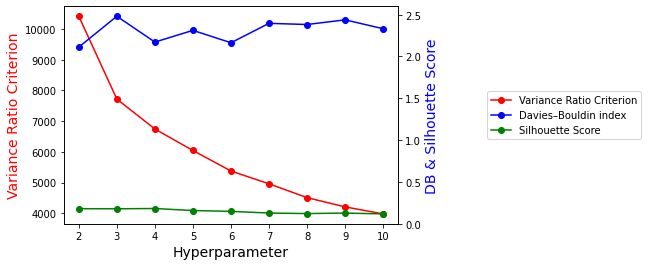

In [12]:
# X-axis values and those to be tested for k
x = np.arange(2, 11)

# placeholders for evaluation measure scores.
VRCLst = []
dBScoreLst = []
silhouetteScoreLst = []

# Test different values for K
for k in x:
    VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, 'euclidean', KMeans(n_clusters=k, random_state=210))
    VRCLst.append(VRC)
    dBScoreLst.append(dBScore)
    silhouetteScoreLst.append(silhouetteScore)

graphResults(x, VRCLst, dBScoreLst, silhouetteScoreLst)

All three measures agree the best number of clusters is 2. The Variance Ratio Criterion signifies the optimal number of clusters at its first local mean. The Davies-Bouldin Index indicated the optimal number of clusters when minimized and the Silhouette Coefficient does when maximized. All of the indications by the three measures agree two is the optimal number of clusters. 

36 components were used to capture 95.0%  of the data's variance.


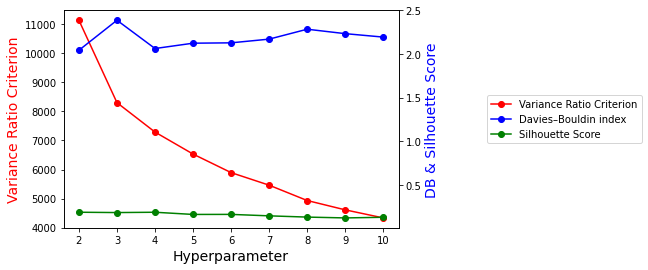

In [13]:
# X-axis values and those to be tested for k
x = np.arange(2, 11)

# placeholders for evaluation measure scores.
VRCLst = []
dBScoreLst = []
silhouetteScoreLst = []

varCaptured = .95

# Test different values for K
for k in x:
    VRC, dBScore, silhouetteScore, mdlLabels, numComp = runPCAClusteringModel(wp_dum, 'euclidean', varCaptured, KMeans(n_clusters=k, random_state=210))
    VRCLst.append(VRC)
    dBScoreLst.append(dBScore)
    silhouetteScoreLst.append(silhouetteScore)

    
print(str(numComp) + ' components were used to capture ' + str(varCaptured*100) + '%  of the data\'s variance.')

graphResults(x, VRCLst, dBScoreLst, silhouetteScoreLst)

The results using the PCA transformed data were similar to the normal data. 

In [14]:
warnings.filterwarnings('ignore')
cv = [(slice(None), slice(None))]
paramDict = {'n_clusters': np.arange(2, 11)}
grid = GridSearchCV(estimator=KMeans(random_state=210), param_grid=paramDict, 
                  scoring=silhouette_scorer, cv=cv, n_jobs=-1)
grid.fit(wp_dum)
print(grid.best_params_) 

{'n_clusters': 2}


Obtain confirmation from GridSearchCV that 2 number of clusters produces the best Silhouette Coefficient. 

In [15]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, silhouetteScoreMeasure, KMeans(n_clusters=2, random_state=210))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 10415.22.
The Davies-Bouldin score is equal to 2.11.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.18.
The model produced 2 clusters.

   Clusters  Number of Instances  Percent of Instances
0         0                30871                0.6128
1         1                19508                0.3872


In [16]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels, numComp = runPCAClusteringModel(wp_dum, silhouetteScoreMeasure, .95, KMeans(n_clusters=2, random_state=210))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 11134.88.
The Davies-Bouldin score is equal to 2.04.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.19.
The model produced 2 clusters.

   Clusters  Number of Instances  Percent of Instances
1         1                30865                0.6127
0         0                19514                0.3873


K-Means clustering with and without PCA transformed data did not perform well. The best Silhouette Coefficient produced was .19. The two clusters may represent functional and non functional water pumps. 

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

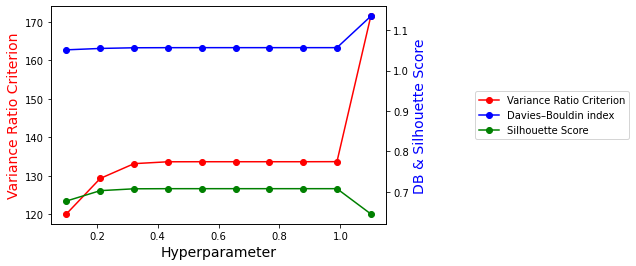

In [17]:
# X-axis values and those to be tested for k
x = np.linspace(.1, 1.1, 10)

# placeholders for evaluation measure scores.
VRCLst = []
dBScoreLst = []
silhouetteScoreLst = []

# Test different values for K
for eps in x:
    VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, 'euclidean', DBSCAN(eps=eps))
    VRCLst.append(VRC)
    dBScoreLst.append(dBScore)
    silhouetteScoreLst.append(silhouetteScore)

graphResults(x, VRCLst, dBScoreLst, silhouetteScoreLst)

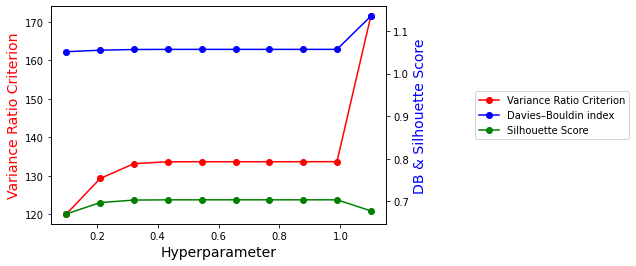

In [18]:
# X-axis values and those to be tested for k
x = np.linspace(.1, 1.1, 10)

# placeholders for evaluation measure scores.
VRCLst = []
dBScoreLst = []
silhouetteScoreLst = []

# Test different values for K
for eps in x:
    VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, 'cosine', DBSCAN(eps=eps))
    VRCLst.append(VRC)
    dBScoreLst.append(dBScore)
    silhouetteScoreLst.append(silhouetteScore)

graphResults(x, VRCLst, dBScoreLst, silhouetteScoreLst)

There is no significant difference between using the Euclidean and cosine distance for the Silhouette Coefficient. The optimal eps value is around .35 where the VRC reaches its local maximum before plateauing. This is also where the Davies-Bouldin score is tied for its minimum value and the Silhouette Coefficient is tied for its maximum value. 

36 components were used to capture 95.0%  of the data's variance.


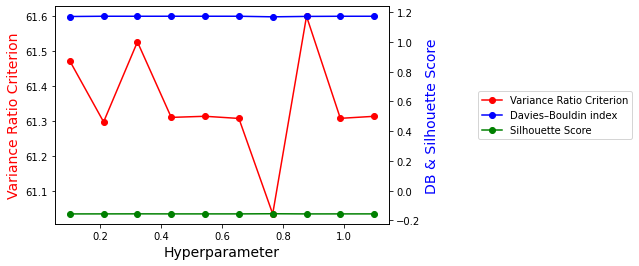

In [19]:
# X-axis values and those to be tested for k
x = np.linspace(.1, 1.1, 10)

# placeholders for evaluation measure scores.
VRCLst = []
dBScoreLst = []
silhouetteScoreLst = []

varCaptured = .95

# Test different values for K
for k in x:
    VRC, dBScore, silhouetteScore, mdlLabels, numComp = runPCAClusteringModel(wp_dum, 'euclidean', varCaptured, DBSCAN(eps=eps))
    VRCLst.append(VRC)
    dBScoreLst.append(dBScore)
    silhouetteScoreLst.append(silhouetteScore)

    
print(str(numComp) + ' components were used to capture ' + str(varCaptured*100) + '%  of the data\'s variance.')

graphResults(x, VRCLst, dBScoreLst, silhouetteScoreLst)

DBSCAN did not perform well using the PCA transformed data. The Silhouette Coefficient remains below zero for all tested eps values. 

In [20]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, silhouetteScoreMeasure, DBSCAN(eps=.32))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 133.04.
The Davies-Bouldin score is equal to 1.06.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.71.
The model produced 1567 clusters.

    Clusters  Number of Instances  Percent of Instances
0         -1                 8089                0.1606
38        37                  692                0.0137
15        14                  652                0.0129
43        42                  604                0.0120
10         9                  524                0.0104


In [21]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, silhouetteScoreMeasure, DBSCAN(eps=.32, metric = 'cosine'))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 8.11.
The Davies-Bouldin score is equal to 1.32.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.12.
The model produced 2 clusters.

   Clusters  Number of Instances  Percent of Instances
1         0                50369            9.9980e-01
2         1                    8            1.5880e-04
0        -1                    2            3.9699e-05


In [22]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, silhouetteScoreMeasure, DBSCAN(eps=.32, min_samples=10))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 138.13.
The Davies-Bouldin score is equal to 1.07.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.58.
The model produced 875 clusters.

    Clusters  Number of Instances  Percent of Instances
0         -1                12626                0.2506
34        33                  692                0.0137
14        13                  652                0.0129
39        38                  604                0.0120
9          8                  524                0.0104


In [23]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, silhouetteScoreMeasure, DBSCAN(eps=.85, min_samples=10))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 138.55.
The Davies-Bouldin score is equal to 1.07.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.58.
The model produced 877 clusters.

    Clusters  Number of Instances  Percent of Instances
0         -1                12566                0.2494
34        33                  692                0.0137
14        13                  652                0.0129
39        38                  604                0.0120
9          8                  524                0.0104


In [24]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, silhouetteScoreMeasure, DBSCAN(eps=.32, min_samples=25))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 167.1.
The Davies-Bouldin score is equal to 1.08.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.36.
The model produced 364 clusters.

    Clusters  Number of Instances  Percent of Instances
0         -1                20201                0.4010
29        28                  692                0.0137
13        12                  652                0.0129
33        32                  604                0.0120
8          7                  524                0.0104


In [25]:
warnings.filterwarnings('ignore')
cv = [(slice(None), slice(None))]
paramDict = {'eps': np.linspace(.1, 1.1, 10)}
grid = GridSearchCV(estimator=DBSCAN(), param_grid=paramDict, 
                  scoring=silhouette_scorer, cv=cv, n_jobs=-1)
grid.fit(wp_dum)
print(grid.best_params_) 

{'eps': 0.1}


GridSearchCV indicates the best eps is 0.1, lower than that indicated by the three measures graphed above.

In [26]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, silhouetteScoreMeasure, DBSCAN(eps=.1))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 120.06.
The Davies-Bouldin score is equal to 1.05.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.68.
The model produced 1580 clusters.

    Clusters  Number of Instances  Percent of Instances
0         -1                 8807                0.1748
38        37                  692                0.0137
15        14                  652                0.0129
43        42                  604                0.0120
10         9                  524                0.0104


In [27]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, silhouetteScoreMeasure, DBSCAN(eps=.32, min_samples=25))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 167.1.
The Davies-Bouldin score is equal to 1.08.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.36.
The model produced 364 clusters.

    Clusters  Number of Instances  Percent of Instances
0         -1                20201                0.4010
29        28                  692                0.0137
13        12                  652                0.0129
33        32                  604                0.0120
8          7                  524                0.0104


Density-Based Spatial Clustering of Applications with Noise is producing too many small clusters to be useful. Noise is accounting for the largest share of instances, then there are hundreds of many small clusters that make up around 1.4% or less of the instances in the data set. 

## Hierarchical Clustering

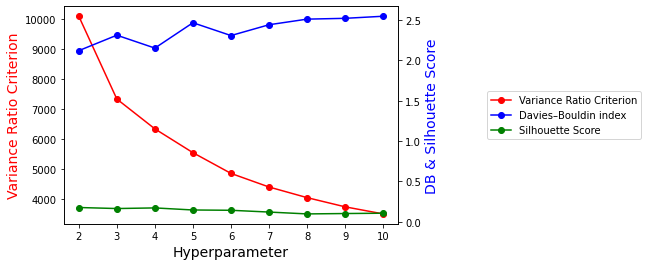

In [28]:
# X-axis values and those to be tested for k
x = np.arange(2, 11)

# placeholders for evaluation measure scores.
VRCLst = []
dBScoreLst = []
silhouetteScoreLst = []

# Test different values for K
for numClusters in x:
    VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, 'euclidean', AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='ward'))
    VRCLst.append(VRC)
    dBScoreLst.append(dBScore)
    silhouetteScoreLst.append(silhouetteScore)

graphResults(x, VRCLst, dBScoreLst, silhouetteScoreLst)

In [29]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, silhouetteScoreMeasure, AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward'))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 10085.83.
The Davies-Bouldin score is equal to 2.12.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.18.
The model produced 2 clusters.

   Clusters  Number of Instances  Percent of Instances
0         0                31676                0.6288
1         1                18703                0.3712


In [30]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, silhouetteScoreMeasure, AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average'))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 307.95.
The Davies-Bouldin score is equal to 1.81.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.17.
The model produced 2 clusters.

   Clusters  Number of Instances  Percent of Instances
0         0                50084                0.9941
1         1                  295                0.0059


In [31]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, silhouetteScoreMeasure, AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete'))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 7245.67.
The Davies-Bouldin score is equal to 2.13.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.14.
The model produced 2 clusters.

   Clusters  Number of Instances  Percent of Instances
0         0                38080                0.7559
1         1                12299                0.2441


In [32]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, silhouetteScoreMeasure, AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single'))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 1.87.
The Davies-Bouldin score is equal to 0.73.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.17.
The model produced 2 clusters.

   Clusters  Number of Instances  Percent of Instances
0         0                50378            9.9998e-01
1         1                    1            1.9850e-05


With Hierarchical Clustering, the ward linkage method performed best in terms of the Silhouette Coefficient. The ward linkage method performed similary to the KMeans method. 

In [33]:
warnings.filterwarnings('ignore')
cv = [(slice(None), slice(None))]
paramDict = {'n_clusters': np.arange(2, 11),}
grid = GridSearchCV(estimator=AgglomerativeClustering(affinity='euclidean', linkage='ward'), param_grid=paramDict, 
                  scoring=silhouette_scorer, cv=cv, n_jobs=-1)
grid.fit(wp_dum)
print(grid.best_params_) 

{'n_clusters': 2}


In [34]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, silhouetteScoreMeasure, AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward'))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 10085.83.
The Davies-Bouldin score is equal to 2.12.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.18.
The model produced 2 clusters.

   Clusters  Number of Instances  Percent of Instances
0         0                31676                0.6288
1         1                18703                0.3712


36 components were used to capture 95.0%  of the data's variance.


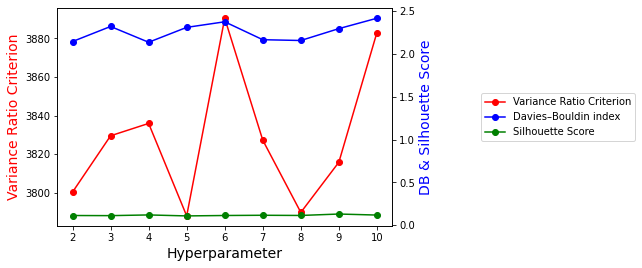

In [35]:
# X-axis values and those to be tested for k
x = np.arange(2, 11)

# placeholders for evaluation measure scores.
VRCLst = []
dBScoreLst = []
silhouetteScoreLst = []

varCaptured = .95

# Test different values for K
for k in x:
    VRC, dBScore, silhouetteScore, mdlLabels, numComp = runPCAClusteringModel(wp_dum, 'euclidean', varCaptured, AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='ward'))
    VRCLst.append(VRC)
    dBScoreLst.append(dBScore)
    silhouetteScoreLst.append(silhouetteScore)

    
print(str(numComp) + ' components were used to capture ' + str(varCaptured*100) + '%  of the data\'s variance.')

graphResults(x, VRCLst, dBScoreLst, silhouetteScoreLst)

In [36]:
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels, numComp = runPCAClusteringModel(wp_dum, silhouetteScoreMeasure, .95, AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward'))
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 9529.56.
The Davies-Bouldin score is equal to 1.98.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.17.
The model produced 2 clusters.

   Clusters  Number of Instances  Percent of Instances
0         0                35950                0.7136
1         1                14429                0.2864


The PCA method does not improve the Silhouette Coefficient and does slightly worst than the non-PCA transformed data. 

## OPTICS

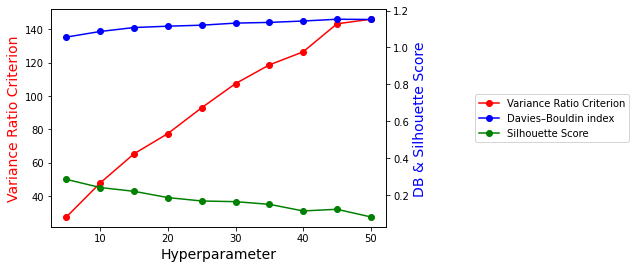

In [37]:
# X-axis values and those to be tested for k
x = np.arange(5, 51, 5)

# placeholders for evaluation measure scores.
VRCLst = []
dBScoreLst = []
silhouetteScoreLst = []

# Test different values for K
for numSamples in x:
    VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, 'euclidean', OPTICS(min_samples=numSamples))
    VRCLst.append(VRC)
    dBScoreLst.append(dBScore)
    silhouetteScoreLst.append(silhouetteScore)

graphResults(x, VRCLst, dBScoreLst, silhouetteScoreLst)

The Davies-Bouldin Index and Silhouette Score agree the default minimum samples of 5 is the best value for the hyperparameter. The Variance Ratio Criterion continues to rise throughout the entire range tested but appears to be plateauing. Due to the high computational cost of running the OPTICS method, only the default value for min_samples was tested, which is the value two of the three measures agreed to be the best hyperparameter. 

In [40]:
warnings.filterwarnings('ignore')
silhouetteScoreMeasure = 'euclidean'
VRC, dBScore, silhouetteScore, mdlLabels = runClusteringModel(wp_dum, silhouetteScoreMeasure, OPTICS())
printClusteringStats(VRC, dBScore, silhouetteScore, silhouetteScoreMeasure, mdlLabels)

The Variance Ratio Criterion is equal to 27.45.
The Davies-Bouldin score is equal to 1.06.
The mean Silhouette Coefficient using the euclidean distance is equal to 0.28.
The model produced 3298 clusters.

      Clusters  Number of Instances  Percent of Instances
0           -1                16574                0.3290
1920      1919                  480                0.0095
1497      1496                  335                0.0066
1701      1700                  295                0.0059
1698      1697                  257                0.0051


The OPTICS measure did not produce useful clusters. Almost a third of the instances are classified as noise and none of the almost 3,300 clusters contain more than a percent of the instances. 

None of the clustering methods achieved a small number of useful clusters with good clustering scoring. The methods either produced too many small clusters with a significant amount of instances classified as noise or a small number of clusters with poor scoring results. Therefore, fitting classification models on the resulting clusters would not be useful.